In [1]:
from ciphers import CryptDataset
from sklearn.model_selection import train_test_split
from ciphers import VigenereCipher
from ciphers import CaesarCipher
from ciphers import AutokeyCipher
from models import EncoderRNN, DecoderRNN
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



vocab_char_to_num = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3,
    'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11,
    'M': 12, 'N': 13, 'O': 14, 'P': 15,
    'Q': 16, 'R': 17, 'S': 18, 'T': 19,
    'U': 20, 'V': 21, 'W': 22, 'X': 23,
    'Y': 24, 'Z': 25, ' ': 26,   '.': 27,  
    ',': 28, '?': 29, '!': 30
}

vocab_num_to_char = {}

for key in vocab_char_to_num:
    vocab_num_to_char[vocab_char_to_num[key]] = key

def string_to_numerical(s):
    return [vocab_char_to_num[c] for c in s]

def numerical_to_string(s):
    return [vocab_num_to_char[c] for c in s]


def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
    return ax


In [2]:
# Easy data
test_data_a = CryptDataset(AutokeyCipher('FOOBAR'), os.path.join('data', 'amazon_test.txt'))
test_data_c = CryptDataset(CaesarCipher(17), os.path.join('data', 'amazon_test.txt'))
test_data_v = CryptDataset(VigenereCipher('RWPFUQBZIRASDLJFUTBSMTRYSFYRMWPCVJDHGFJSDMFJNEDFGV'), os.path.join('data', 'amazon_test.txt'))


# Create data loaders
test_data_loader_a = DataLoader(test_data_a, batch_size=512, shuffle=True)
test_data_loader_v = DataLoader(test_data_v, batch_size=512, shuffle=True)
test_data_loader_c= DataLoader(test_data_c, batch_size=512, shuffle=True)

# Load easy models
from models import EncoderRNN, DecoderRNN
import torch


# Ceaser - Same Shift Training
encoder_state_dict_c = torch.load('encoder_ceaser_cipher_2048_rand.pth')
decoder_state_dict_c = torch.load('decoder_ceaser_cipher_2048_rand.pth')

encoder_c = EncoderRNN(31, 2048)
decoder_c = DecoderRNN(2048, 31)

encoder_c.load_state_dict(encoder_state_dict_c)
decoder_c.load_state_dict(decoder_state_dict_c)


# Autokey - Same Key Training
encoder_state_dict_a = torch.load('encoder_autokey_cipher_2048_rand.pth')
decoder_state_dict_a = torch.load('decoder_autokey_cipher_2048_rand.pth')

encoder_a = EncoderRNN(31, 2048)
decoder_a = DecoderRNN(2048, 31)

encoder_a.load_state_dict(encoder_state_dict_a)
decoder_a.load_state_dict(decoder_state_dict_a)


# Vigenere - Same Key training
encoder_state_dict_v = torch.load('encoder_vigenere_hard_cipher_2048.pth')
decoder_state_dict_v = torch.load('decoder_vigenere_hard_cipher_2048.pth')

encoder_v = EncoderRNN(31, 2048)
decoder_v = DecoderRNN(2048, 31)

encoder_v.load_state_dict(encoder_state_dict_v)
decoder_v.load_state_dict(decoder_state_dict_v)

device = 'cuda:0'

models = [encoder_v, encoder_c, encoder_a, decoder_v, decoder_c, decoder_a]

for m in models:
    m.to(device)
    m.eval()


In [3]:
# loss throughout training
# also see how it does per letter


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.2864190365641323
{' ': 0.6028901365512089, 'I': 0.18297447079131463, 'E': 0.1745889036562166, 'T': 0.1737166575108344, 'H': 0.17140090380890896, 'A': 0.1581565105378037, 'S': 0.15458591461096324, 'O': 0.15022775529463006, 'P': 0.13789909556499946, 'V': 0.12845634661441324, '!': 0.12345346960731576, 'N': 0.11978431417925992, 'L': 0.11897138282969782, 'R': 0.11482752603106276, 'D': 0.10767606695822651, 'W': 0.10441884205920957, 'G': 0.10426481527398959, 'F': 0.10207404261343526, 'M': 0.09454136184580754, 'U': 0.09352862339651541, 'Y': 0.0927437641723356, 'K': 0.08452151573538856, '.': 0.07901067508645317, 'J': 0.07410236822001529, 'C': 0.07262748101346608, 'B': 0.06853884226382613, 'X': 0.03952205882352941, 'Q': 0.03678474114441417, ',': 0.031828978622327794, 'Z': 0.027827648114901255, '?': 0.0}


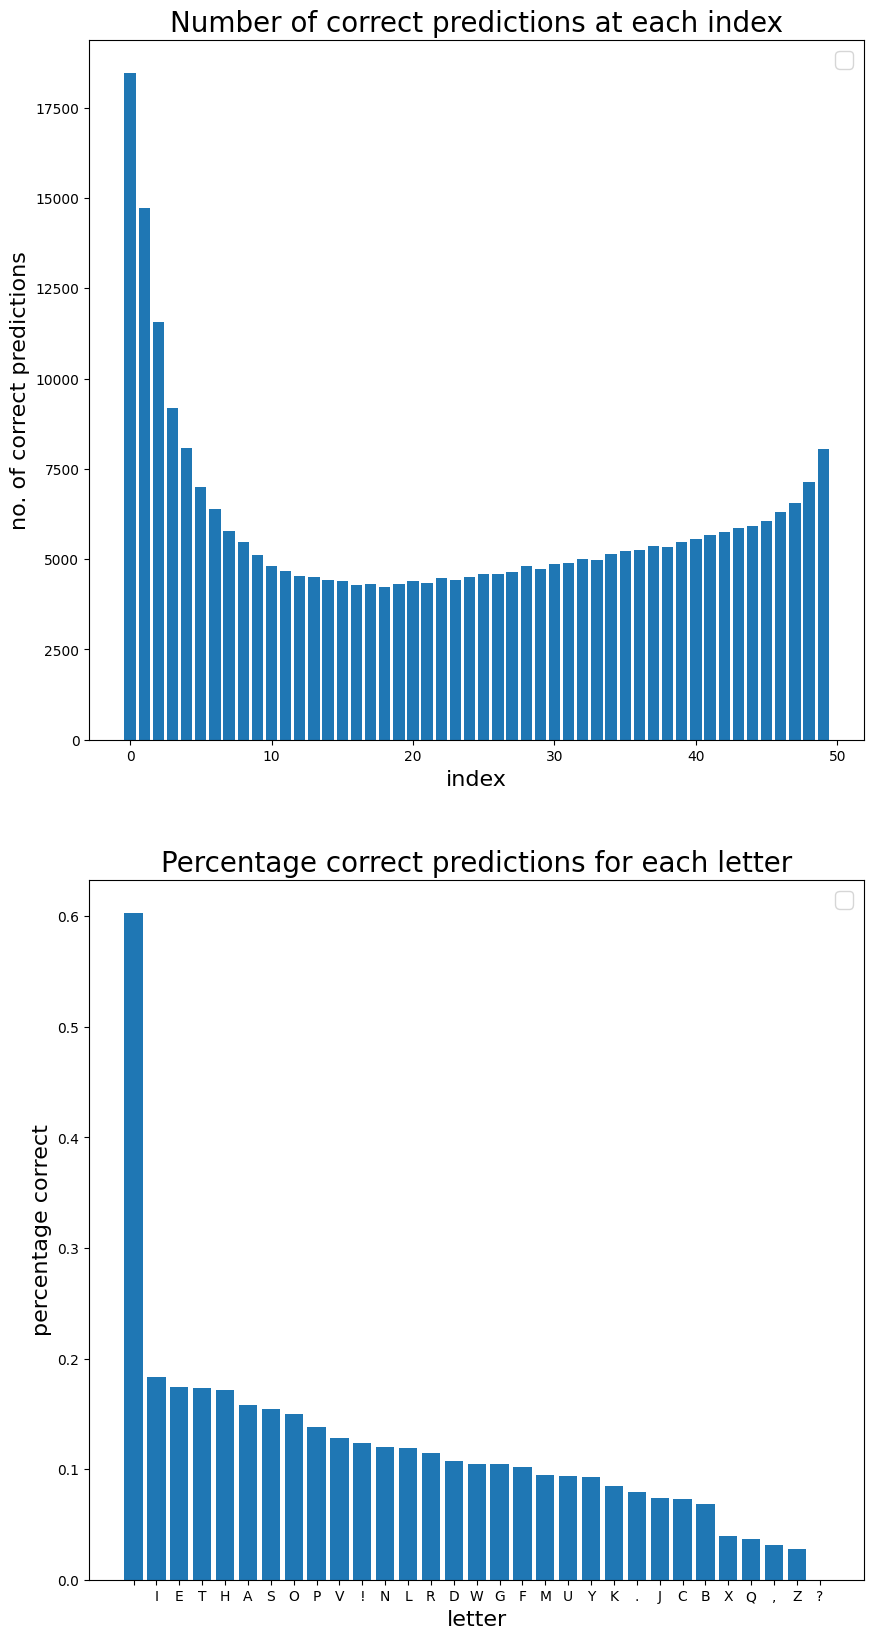

In [4]:
# Final accuracies on test set
device= 'cuda'

def test_and_create_plots(encoder, decoder, data_loader):
    total_len = 0
    total_right = 0
    right_at_index = {x: 0 for x in range(0, 50)}
    # the first item in the list is for correct counting, the second for incorrect counting
    correct_char = {x: [0, 0] for x in vocab_char_to_num.keys()}
    for cipher, clear in data_loader:
        cipher, clear = cipher.to(device), clear.to(device)

        encoder_outputs, encoder_hidden = encoder(cipher)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_letters = []
        decoded_messages = [numerical_to_string(x.tolist()) for x in decoded_ids]
        clear = [numerical_to_string(x.tolist()) for x in clear]



        for clear_pred, clear_actual in zip(decoded_messages, clear):
            total_len += len(clear_actual)
            index = 0
            for pred_char, clear_char in zip(clear_pred, clear_actual):
                if pred_char == clear_char:
                    total_right += 1

                    right_at_index[index] += 1
                    correct_char[clear_char][0] += 1
                else:
                    correct_char[clear_char][1] += 1
                index += 1

    print(f'Accuracy: {total_right / total_len}')

    correct_char_percentages = dict(sorted({x: correct_char[x][0] / (correct_char[x][0] + correct_char[x][1]) for x in correct_char.keys()}.items(), key=lambda x : x[1], reverse=True))
    print(correct_char_percentages)
    fig, ax = plt.subplots(figsize=(10, 20), nrows=2)


    ax[0].bar(right_at_index.keys(), right_at_index.values())
    ax[1].bar(correct_char_percentages.keys(), correct_char_percentages.values())
    make_pretty(ax[0], 'Number of correct predictions at each index', 'index', 'no. of correct predictions')
    make_pretty(ax[1], 'Percentage correct predictions for each letter', 'letter', 'percentage correct')
    

test_and_create_plots(encoder_c, decoder_c, test_data_loader_c)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.2233236602824531
{' ': 0.5727589903044694, '!': 0.1406670252824099, 'E': 0.09681286321111197, 'T': 0.09096319355429408, 'I': 0.08287453438720814, 'A': 0.07922138333273697, 'O': 0.06923398000108887, 'S': 0.06854829691588576, 'H': 0.058973531310522916, 'N': 0.05748536252343153, 'R': 0.04307486475481356, 'D': 0.038908158648770924, 'P': 0.03884711779448621, 'L': 0.037188980054699484, '.': 0.03337843933243121, 'U': 0.028384070457591424, 'M': 0.02661789532920653, 'G': 0.025539300768658568, 'C': 0.02469844916714532, '?': 0.024024024024024024, 'Y': 0.023639455782312926, 'F': 0.023501097189778438, 'W': 0.02275047396820767, 'V': 0.017635532331809273, 'B': 0.015171078114912848, 'K': 0.012845215157353885, ',': 0.0059382422802850355, 'Z': 0.0026929982046678637, 'J': 0.0015278838808250573, 'Q': 0.0013623978201634877, 'X': 0.0}


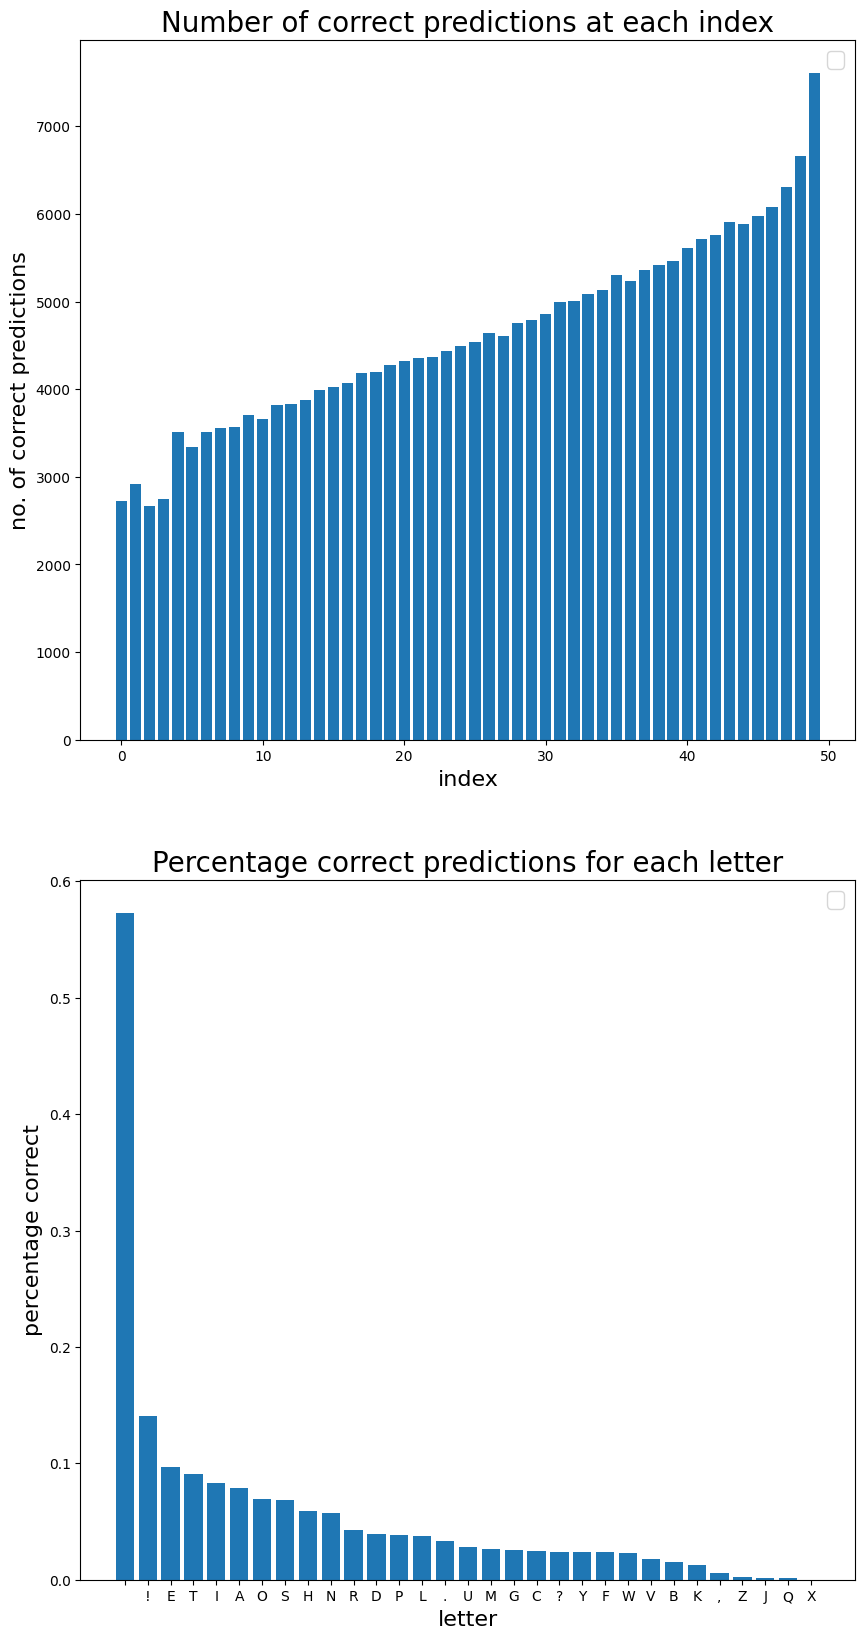

In [5]:
test_and_create_plots(encoder_a, decoder_a, test_data_loader_a)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.10385277616560264
{' ': 0.22088380242130162, 'E': 0.08840851640476377, 'T': 0.07080510285051578, 'O': 0.06683846614521895, 'A': 0.06467599384549326, 'I': 0.06423185245752702, 'S': 0.05694093440386465, 'N': 0.04693249404086922, 'H': 0.04683666881859264, 'L': 0.040224134480688414, 'R': 0.03498923855505788, 'D': 0.029369627507163324, 'P': 0.02822273073989321, 'U': 0.021395749569213095, 'Y': 0.020975056689342405, 'M': 0.019245920090039392, 'G': 0.018534589635507068, 'C': 0.017295296445210287, 'W': 0.01720869184774683, 'F': 0.016634812769873292, 'V': 0.013063357282821686, '.': 0.011201323109306872, 'K': 0.008606294155427104, 'B': 0.008069722401549387, 'Z': 0.0026929982046678637, ',': 0.0021377672209026127, 'X': 0.001838235294117647, 'Q': 0.0013623978201634877, '!': 0.0010758472296933835, 'J': 0.0007639419404125286, '?': 0.0}


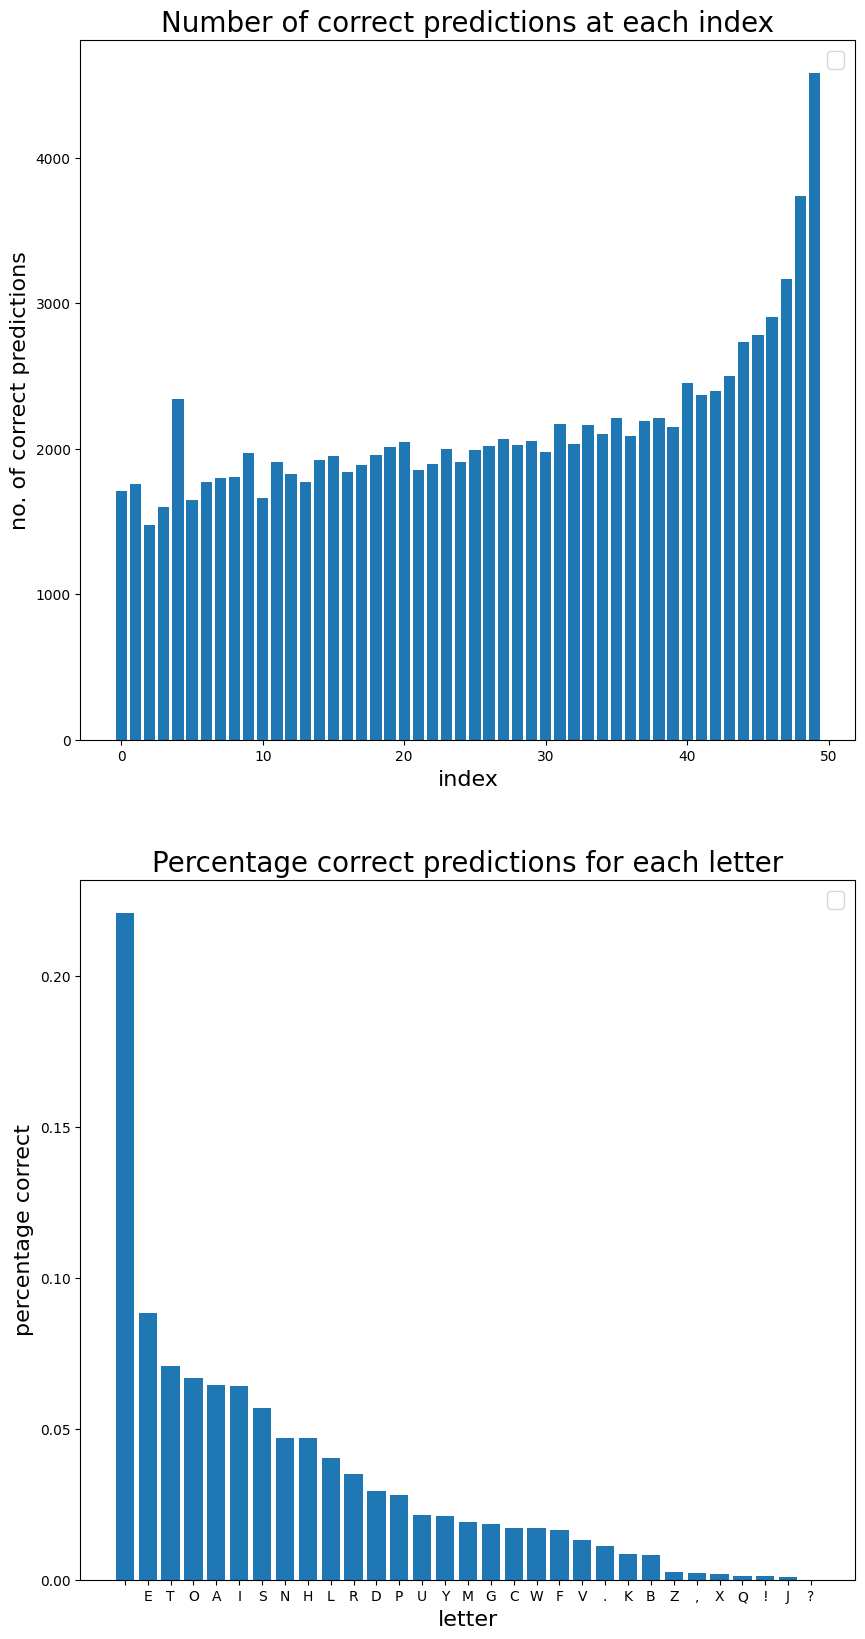

In [6]:
test_and_create_plots(encoder_v, decoder_v, test_data_loader_v)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1m 2s (- 51m 21s) (1 2%) 2.2334
2m 5s (- 50m 19s) (2 4%) 1.7089
3m 9s (- 49m 22s) (3 6%) 1.4617
4m 12s (- 48m 23s) (4 8%) 1.2702
5m 15s (- 47m 21s) (5 10%) 1.1431
6m 19s (- 46m 20s) (6 12%) 1.0515
7m 22s (- 45m 17s) (7 14%) 0.9850
8m 25s (- 44m 15s) (8 16%) 0.9371
9m 29s (- 43m 13s) (9 18%) 0.8903
10m 32s (- 42m 11s) (10 20%) 0.8545
11m 36s (- 41m 8s) (11 22%) 0.8277
12m 39s (- 40m 5s) (12 24%) 0.7890
13m 43s (- 39m 2s) (13 26%) 0.7787
14m 46s (- 37m 59s) (14 28%) 0.7375
15m 49s (- 36m 56s) (15 30%) 0.7184
16m 53s (- 35m 53s) (16 32%) 0.6923
17m 56s (- 34m 50s) (17 34%) 0.6720
19m 0s (- 33m 47s) (18 36%) 0.6692
20m 3s (- 32m 44s) (19 38%) 0.6267
21m 7s (- 31m 40s) (20 40%) 0.6127
22m 10s (- 30m 37s) (21 42%) 0.5804
23m 14s (- 29m 34s) (22 44%) 0.5701
24m 17s (- 28m 31s) (23 46%) 0.5519
25m 21s (- 27m 27s) (24 48%) 0.5499
26m 24s (- 26m 24s) (25 50%) 0.5119
27m 28s (- 25m 21s) (26 52%) 0.5259
28m 31s (- 24m 18s) (27 54%) 0.4858
29m 35s (- 23m 14s) (28 56%) 0.4854
30m 38s (- 22m 11s) (29

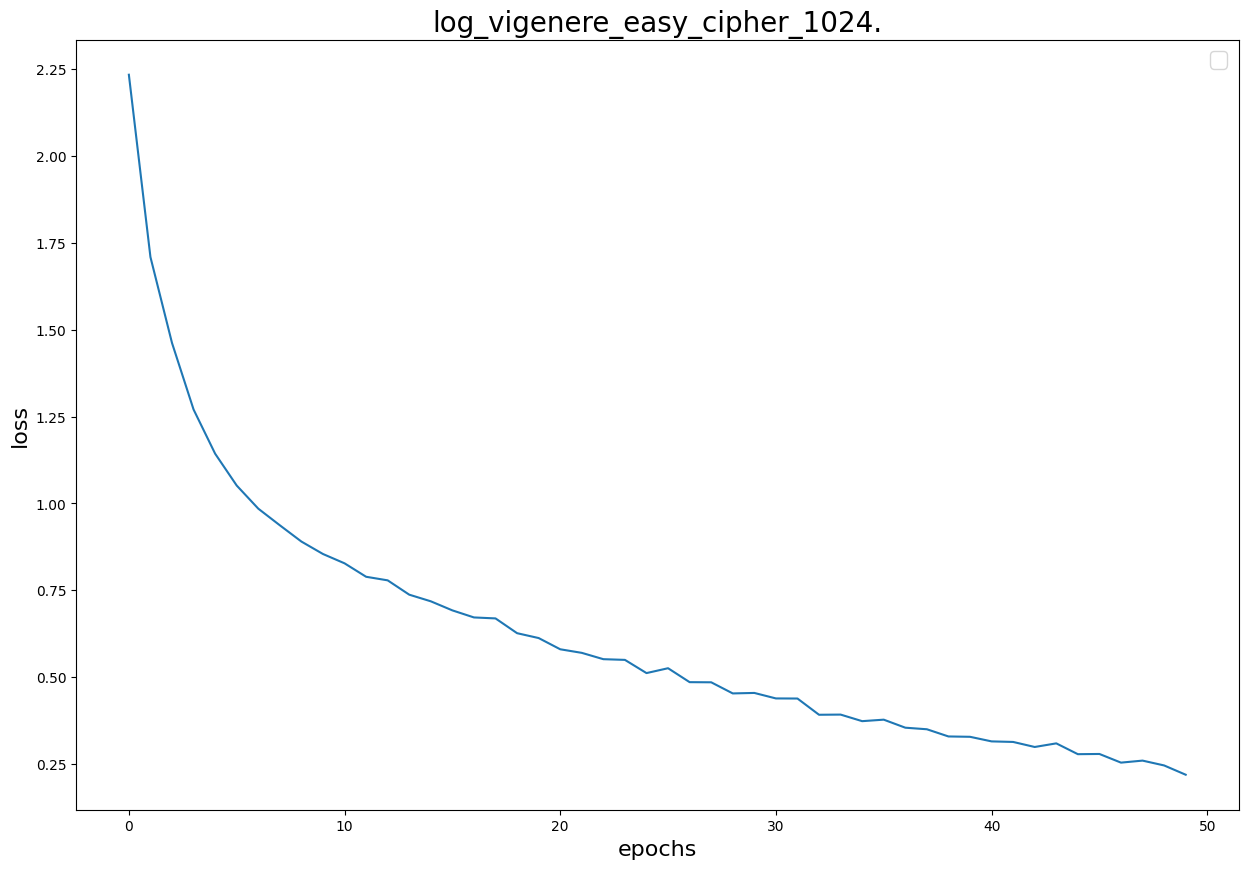

In [7]:

def read_and_plot(title):
    with open(title, 'r') as f:
        content = f.read()
        
        
    epoch_loss = {}
    for i, line in enumerate(content.split('\n')):
        print(line)
        if line.strip() != "":
            epoch_loss[i] = float(line.split()[-1])
        
    print(epoch_loss)
    epochs = epoch_loss.keys()
    losses = epoch_loss.values()
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    ax.plot(epochs, losses)
        
        
    make_pretty(ax, title.replace('txt', ''), 'epochs', 'loss')
        
        

        
read_and_plot('log_vigenere_easy_cipher_1024.txt')
